In [2]:
import pandas as pd
import xmltodict, requests

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [3]:
# Import all csvs

SEASONS_CSV = pd.read_csv(r"f1data/seasons.csv")
CIRCUITS_CSV = pd.read_csv(r"f1data/circuits.csv")
RESULTS_CSV = pd.read_csv(r"f1data/results.csv")

In [4]:
# ---------------------------------------------
# Getting Years to Start Data

DATA = pd.DataFrame(SEASONS_CSV)
DATA.sort_values("year", ascending=False, inplace=True)
DATA.reset_index(inplace=True)
DATA.drop(columns=["url", "index"], inplace=True)
DATA

,year
0,2022
1,2021
2,2020
3,2019
4,2018
...,...
68,1954
69,1953
70,1952
71,1951


In [5]:
# Get Number of Rounds

number_of_rounds = []
for index, row in DATA.iterrows():
    req = requests.get("http://ergast.com/api/f1/{0}".format(row["year"]))

    dict = xmltodict.parse(req.content)
    number_of_rounds.append(dict["MRData"]["@total"])

In [6]:
# ---------------------------------------------
rounds = pd.DataFrame(number_of_rounds)
rounds.rename(columns = {0 : "rounds"}, inplace = True)
rounds

DATA = pd.concat([DATA, rounds], axis = 1, sort=False)
DATA

,year,rounds
0,2022,22
1,2021,22
2,2020,17
3,2019,21
4,2018,21
...,...,...
68,1954,9
69,1953,9
70,1952,8
71,1951,8


In [7]:
RACE_TIMES = {}

for index, row in DATA.iterrows():
    year_races_times = {}

    year = row["year"]
    numofrounds = row["rounds"]
    # year = 2000
    # numofrounds = "17"

    for round in range(1,int(numofrounds) + 1):
        req = requests.get("http://ergast.com/api/f1/{0}/{1}/qualifying".format(year, round))

        dict = xmltodict.parse(req.content)
        circuit, fastest_quali_lap = None, None
        try:
            circuit = dict["MRData"]["RaceTable"]["Race"]["Circuit"]["CircuitName"]

            fastest_quali_lap = dict["MRData"]["RaceTable"]["Race"]["QualifyingList"]["QualifyingResult"][0]["Q1"]
            fastest_quali_lap = dict["MRData"]["RaceTable"]["Race"]["QualifyingList"]["QualifyingResult"][0]["Q2"]
            fastest_quali_lap = dict["MRData"]["RaceTable"]["Race"]["QualifyingList"]["QualifyingResult"][0]["Q3"]
        except KeyError:
            if "Race" not in dict["MRData"]["RaceTable"]:
                continue
            else:
                pass
        finally:
            if circuit == None and circuit == None:
                continue
            else:
                year_races_times[str(circuit)] = fastest_quali_lap

    RACE_TIMES[str(year)] = year_races_times

In [8]:
# ---------------------------------------------
# Remove all rows that contain completely NaN

ALL_TIMES = pd.DataFrame(RACE_TIMES).transpose()
ALL_TIMES.dropna(how="all", inplace=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(ALL_TIMES)

,Bahrain International Circuit,Jeddah Corniche Circuit,Albert Park Grand Prix Circuit,Autodromo Enzo e Dino Ferrari,Miami International Autodrome,Circuit de Barcelona-Catalunya,Circuit de Monaco,Baku City Circuit,Circuit Gilles Villeneuve,Silverstone Circuit,Red Bull Ring,Circuit Paul Ricard,Hungaroring,Circuit de Spa-Francorchamps,Circuit Park Zandvoort,Autodromo Nazionale di Monza,Marina Bay Street Circuit,Suzuka Circuit,Circuit of the Americas,Autódromo Hermanos Rodríguez,Autódromo José Carlos Pace,Yas Marina Circuit,Autódromo Internacional do Algarve,Sochi Autodrom,Istanbul Park,Losail International Circuit,Autodromo Internazionale del Mugello,Nürburgring,Shanghai International Circuit,Hockenheimring,Sepang International Circuit,Korean International Circuit,Buddh International Circuit,Valencia Street Circuit,Circuit de Nevers Magny-Cours,Fuji Speedway,Indianapolis Motor Speedway,Autódromo Juan y Oscar Gálvez,Autódromo do Estoril,Okayama International Circuit,Adelaide Street Circuit,Circuito de Jerez
2022,1:30.558,1:28.200,1:17.868,1:27.999,1:28.796,1:18.750,1:11.376,1:41.359,1:21.299,1:40.983,1:04.984,1:30.872,1:17.377,1:43.665,1:10.342,1:20.161,1:49.412,1:29.304,1:34.356,1:17.775,1:11.674,1:23.824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,1:28.997,1:27.511,NaN,1:14.411,NaN,1:16.741,1:10.346,1:41.218,NaN,1:26.134,1:03.720,1:29.990,1:15.419,1:59.765,1:08.885,1:19.555,NaN,NaN,1:32.910,1:15.875,1:07.934,1:22.109,1:18.348,1:41.993,1:22.868,1:20.827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,0:53.377,NaN,NaN,1:13.609,NaN,1:15.584,NaN,NaN,NaN,1:25.154,1:19.273,NaN,1:13.447,1:41.252,NaN,1:18.887,NaN,NaN,NaN,NaN,NaN,1:35.246,1:16.652,1:31.304,1:47.765,NaN,1:15.144,1:25.269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,1:27.866,NaN,1:20.486,NaN,NaN,1:15.406,1:10.166,1:40.495,1:10.240,1:25.093,1:03.003,1:28.319,1:14.572,1:42.519,NaN,1:19.307,1:36.217,1:27.064,1:32.029,1:14.758,1:07.508,1:34.779,NaN,1:31.628,NaN,NaN,NaN,NaN,1:31.547,1:11.767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018,1:27.958,NaN,1:21.164,NaN,NaN,1:16.173,1:10.810,1:41.498,1:10.764,1:25.892,1:03.130,1:30.029,1:35.658,1:58.179,NaN,1:19.119,1:36.015,1:27.760,1:32.237,1:14.759,1:07.281,1:34.794,NaN,1:31.387,NaN,NaN,NaN,NaN,1:31.095,1:11.212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,1:28.769,NaN,1:22.188,NaN,NaN,1:19.149,1:12.178,1:40.593,1:11.459,1:26.600,1:04.251,NaN,1:16.276,1:42.553,NaN,1:35.554,1:39.491,1:27.319,1:33.108,1:16.488,1:08.322,1:36.231,NaN,1:33.194,NaN,NaN,NaN,NaN,1:31.678,NaN,1:30.076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,1:29.493,NaN,1:23.837,NaN,NaN,1:22.000,1:13.622,1:42.758,1:12.812,1:29.287,1:07.922,NaN,1:19.965,1:46.744,NaN,1:21.135,1:42.584,1:30.647,1:34.999,1:18.704,1:10.736,1:38.755,NaN,1:35.417,NaN,NaN,NaN,NaN,1:35.402,1:14.363,1:32.850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,1:32.571,NaN,1:26.327,NaN,NaN,1:24.681,1:15.098,NaN,1:14.393,1:32.248,1:08.455,NaN,1:22.020,1:47.197,NaN,1:23.397,1:43.885,1:32.584,1:56.824,1:19.480,1:11.282,1:40.237,NaN,1:37.113,NaN,NaN,NaN,NaN,1:35.782,NaN,1:49.834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,1:33.185,NaN,1:44.231,NaN,NaN,1:25.232,1:15.989,NaN,1:14.874,1:35.766,1:08.759,NaN,1:22.715,2:05.591,NaN,1:24.109,1:45.681,1:32.506,1:36.067,NaN,1:10.023,1:40.480,NaN,1:38.513,NaN,NaN,NaN,NaN,1:53.860,1:16.540,1:59.431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,1:32.330,NaN,1:27.407,NaN,NaN,1:20.718,1:13.876,NaN,1:25.425,1:29.607,NaN,NaN,1:19.388,2:01.012,NaN,1:23.755,1:42.841,1:30.915,1:36.338,NaN,1:26.479,1:39.957,NaN,NaN,NaN,NaN,NaN,1:29.398,1:34.484,NaN,1:49.674,1:37.202,1:24.119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
from datetime import datetime

def convert_to_seconds(raw_t):
    x = datetime.strptime(raw_t,"%M:%S.%f")
    return x.minute*60+x.second+x.microsecond/1000000

In [10]:
# -----------------------------------------------------------
for rowindex, row in ALL_TIMES.iterrows():
    for columnindex, value in row.items():
        if columnindex == 0 or not isinstance(value, str):
            continue
        ALL_TIMES.at[rowindex, columnindex] = float(convert_to_seconds(value))
        # print(str(value) + "     " + str(type(value)))

In [11]:
for col in ALL_TIMES.columns:
    ALL_TIMES[col] = pd.to_numeric(ALL_TIMES[col])
ALL_TIMES

,Bahrain International Circuit,Jeddah Corniche Circuit,Albert Park Grand Prix Circuit,Autodromo Enzo e Dino Ferrari,Miami International Autodrome,Circuit de Barcelona-Catalunya,Circuit de Monaco,Baku City Circuit,Circuit Gilles Villeneuve,Silverstone Circuit,Red Bull Ring,Circuit Paul Ricard,Hungaroring,Circuit de Spa-Francorchamps,Circuit Park Zandvoort,Autodromo Nazionale di Monza,Marina Bay Street Circuit,Suzuka Circuit,Circuit of the Americas,Autódromo Hermanos Rodríguez,Autódromo José Carlos Pace,Yas Marina Circuit,Autódromo Internacional do Algarve,Sochi Autodrom,Istanbul Park,Losail International Circuit,Autodromo Internazionale del Mugello,Nürburgring,Shanghai International Circuit,Hockenheimring,Sepang International Circuit,Korean International Circuit,Buddh International Circuit,Valencia Street Circuit,Circuit de Nevers Magny-Cours,Fuji Speedway,Indianapolis Motor Speedway,Autódromo Juan y Oscar Gálvez,Autódromo do Estoril,Okayama International Circuit,Adelaide Street Circuit,Circuito de Jerez
2022,90.558,88.200,77.868,87.999,88.796,78.750,71.376,101.359,81.299,100.983,64.984,90.872,77.377,103.665,70.342,80.161,109.412,89.304,94.356,77.775,71.674,83.824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,88.997,87.511,NaN,74.411,NaN,76.741,70.346,101.218,NaN,86.134,63.720,89.990,75.419,119.765,68.885,79.555,NaN,NaN,92.910,75.875,67.934,82.109,78.348,101.993,82.868,80.827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,53.377,NaN,NaN,73.609,NaN,75.584,NaN,NaN,NaN,85.154,79.273,NaN,73.447,101.252,NaN,78.887,NaN,NaN,NaN,NaN,NaN,95.246,76.652,91.304,107.765,NaN,75.144,85.269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,87.866,NaN,80.486,NaN,NaN,75.406,70.166,100.495,70.240,85.093,63.003,88.319,74.572,102.519,NaN,79.307,96.217,87.064,92.029,74.758,67.508,94.779,NaN,91.628,NaN,NaN,NaN,NaN,91.547,71.767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018,87.958,NaN,81.164,NaN,NaN,76.173,70.810,101.498,70.764,85.892,63.130,90.029,95.658,118.179,NaN,79.119,96.015,87.760,92.237,74.759,67.281,94.794,NaN,91.387,NaN,NaN,NaN,NaN,91.095,71.212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,88.769,NaN,82.188,NaN,NaN,79.149,72.178,100.593,71.459,86.600,64.251,NaN,76.276,102.553,NaN,95.554,99.491,87.319,93.108,76.488,68.322,96.231,NaN,93.194,NaN,NaN,NaN,NaN,91.678,NaN,90.076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,89.493,NaN,83.837,NaN,NaN,82.000,73.622,102.758,72.812,89.287,67.922,NaN,79.965,106.744,NaN,81.135,102.584,90.647,94.999,78.704,70.736,98.755,NaN,95.417,NaN,NaN,NaN,NaN,95.402,74.363,92.850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,92.571,NaN,86.327,NaN,NaN,84.681,75.098,NaN,74.393,92.248,68.455,NaN,82.020,107.197,NaN,83.397,103.885,92.584,116.824,79.480,71.282,100.237,NaN,97.113,NaN,NaN,NaN,NaN,95.782,NaN,109.834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,93.185,NaN,104.231,NaN,NaN,85.232,75.989,NaN,74.874,95.766,68.759,NaN,82.715,125.591,NaN,84.109,105.681,92.506,96.067,NaN,70.023,100.480,NaN,98.513,NaN,NaN,NaN,NaN,113.860,76.540,119.431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,92.330,NaN,87.407,NaN,NaN,80.718,73.876,NaN,85.425,89.607,NaN,NaN,79.388,121.012,NaN,83.755,102.841,90.915,96.338,NaN,86.479,99.957,NaN,NaN,NaN,NaN,NaN,89.398,94.484,NaN,109.674,97.202,84.119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
YEARS_OF_FASTEST_TIMES = pd.DataFrame(ALL_TIMES.idxmin())
YEARS_OF_FASTEST_TIMES.rename(columns = {0 : "year"}, inplace = True)
# YEARS_OF_FASTEST_TIMES = YEARS_OF_FASTEST_TIMES.transpose()
YEARS_OF_FASTEST_TIMES

,year
Bahrain International Circuit,2020
Jeddah Corniche Circuit,2021
Albert Park Grand Prix Circuit,2022
Autodromo Enzo e Dino Ferrari,2020
Miami International Autodrome,2022
Circuit de Barcelona-Catalunya,2006
Circuit de Monaco,2019
Baku City Circuit,2019
Circuit Gilles Villeneuve,2019
Silverstone Circuit,2004


In [28]:
OCCURANCES = YEARS_OF_FASTEST_TIMES["year"].value_counts()
OCCURANCES

2020    8
2019    8
2021    5
2018    4
2004    3
1994    3
2022    2
1995    2
2006    1
2017    1
2010    1
2013    1
2011    1
2008    1
1997    1
Name: year, dtype: int64

In [29]:
OCCURANCES = pd.DataFrame(OCCURANCES)
OCCURANCES.reset_index(inplace=True)
OCCURANCES.rename(columns={"year":"occurances", "index":"year"}, inplace=True)
OCCURANCES

,year,occurances
0,2020,8
1,2019,8
2,2021,5
3,2018,4
4,2004,3
5,1994,3
6,2022,2
7,1995,2
8,2006,1
9,2017,1


In [15]:
import seaborn as graph

<AxesSubplot: xlabel='occurances', ylabel='year'>

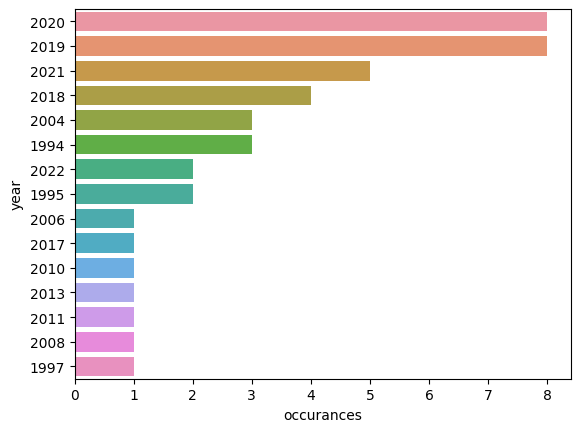

In [33]:
graph.barplot(data=OCCURANCES, y="year", x="occurances")